# Advanced XGBoost Model with NLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
import tensorflow_hub as hub
import xgboost as xgb

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score

from imblearn.over_sampling import RandomOverSampler

import random

import joblib

%matplotlib inline

Using TensorFlow backend.


In [2]:
def confusion_reporting(true_values, pred_values):
    '''
    This function takes in the true values of a dataset and the predicted values
    of the dataset and prints out a classification report, accuracy score, and
    plots the confusion matrix of the true and predicted values for simple analysis
    '''
    print(confusion_matrix(true_values, pred_values))
    print(classification_report(true_values, pred_values))
    print('Accuracy score:', round(accuracy_score(true_values, pred_values), 4))
    print('F1 score:', round(f1_score(true_values, pred_values), 4))

    cm = confusion_matrix(true_values, pred_values)
    df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                         index=['F', 'T'],
                         columns=['F', 'T'])
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, cmap='Greens', vmin=0, vmax=1)
    plt.xlabel('Pred Val')
    plt.ylabel('True Val')
    plt.show()

In [3]:
main_df = pd.read_pickle('main_df.pkl')

display(main_df.head())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsor_my_party,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R
5,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,1,4.0,1,1,0,1,0,1,1,0
12,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,1,4.0,1,1,0,1,1,1,0,0
18,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,1,4.0,1,1,0,1,0,1,1,0
24,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,1,4.0,1,1,0,1,1,1,0,0
30,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,1,4.0,1,1,0,1,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 102692 entries, 5 to 306260
Data columns (total 78 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   congress                       102692 non-null  int64  
 1   chamber                        102692 non-null  object 
 2   rollnumber                     102692 non-null  int64  
 3   icpsr                          102692 non-null  int64  
 4   cast_code                      102692 non-null  int64  
 5   state_abbrev                   102692 non-null  object 
 6   bioname                        102692 non-null  object 
 7   bioguide_id                    102692 non-null  object 
 8   born                           102692 non-null  int64  
 9   nominate_dim1                  102692 non-null  float64
 10  nominate_dim2                  102692 non-null  float64
 11  party                          102692 non-null  object 
 12  last_name                     

None

#### Drop all roll numbers excepts last for each bill

In [4]:
last_roll_per_bill = main_df.groupby(['congress', 'bill_number']).rollnumber.max().reset_index()
last_roll_per_bill.columns = ['congress', 'bill_number', 'last_rollcall']
main_df_last_roll = main_df.merge(last_roll_per_bill, how='left', on=['congress', 'bill_number'])

main_df = main_df_last_roll[main_df_last_roll['rollnumber'] == main_df_last_roll['last_rollcall']]

main_df = main_df.reset_index(drop=True)

display(main_df.head())
display(main_df.tail())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R,last_rollcall
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,4.0,1,1,0,1,0,1,1,0,1
1,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,4.0,1,1,0,1,1,1,0,0,1
2,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,4.0,1,1,0,1,0,1,1,0,1
3,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,4.0,1,1,0,1,1,1,0,0,1
4,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,4.0,1,1,0,1,1,1,0,0,1


,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R,last_rollcall
23221,116,Senate,508,49300,1,CA,"FEINSTEIN, Dianne",F000062,1933,-0.268,...,136161.0,40401,28224,0,40401,1,1,0,0,508
23222,116,Senate,508,49308,1,WA,"MURRAY, Patty",M001111,1950,-0.350,...,136161.0,40401,28224,0,40401,1,1,0,0,508
23223,116,Senate,508,49703,1,ME,"COLLINS, Susan Margaret",C001035,1952,0.112,...,136161.0,40401,28224,0,28224,0,1,1,0,508
23224,116,Senate,508,49706,1,WY,"ENZI, Michael B.",E000285,1944,0.544,...,136161.0,40401,28224,0,28224,0,1,1,0,508
23225,116,Senate,508,94659,1,AL,"SHELBY, Richard C.",S000320,1934,0.428,...,136161.0,40401,28224,0,28224,0,1,1,0,508


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23226 entries, 0 to 23225
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   congress                       23226 non-null  int64  
 1   chamber                        23226 non-null  object 
 2   rollnumber                     23226 non-null  int64  
 3   icpsr                          23226 non-null  int64  
 4   cast_code                      23226 non-null  int64  
 5   state_abbrev                   23226 non-null  object 
 6   bioname                        23226 non-null  object 
 7   bioguide_id                    23226 non-null  object 
 8   born                           23226 non-null  int64  
 9   nominate_dim1                  23226 non-null  float64
 10  nominate_dim2                  23226 non-null  float64
 11  party                          23226 non-null  object 
 12  last_name                      23226 non-null 

None

## XGBoost - No summary, same features as Logit

In [5]:
dep_col = 'cast_code'
logit_features = pd.read_pickle("final_features.pkl")

In [6]:
logit_features

,feature,importance
0,sponsor_is_same_party,0.094584
1,nominate_dim1,0.093084
2,cosponsor_my_party,0.087211
3,age,0.071913
4,tenure,0.068486
5,nominate_dim2,0.059010
6,cosponsor_my_party^2,0.053326
7,percent_campaign_vote,0.052812
8,cosponsors^2,0.047311
9,cosponsors,0.042348


#### Random sampling of all bills

In [7]:
scalar = StandardScaler()

y = main_df[dep_col]
X = main_df[logit_features['feature'].values]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_sc = scalar.fit_transform(X_train)
X_test_sc = scalar.transform(X_test)

#### Whole bills set aside for test - randomly

In [8]:
main_df['bill_slug'] = main_df['bill_number'] + '-' + main_df['congress'].apply(lambda x: str(x))

In [9]:
unique_bills = list(main_df['bill_slug'].unique())
percent_to_subset = .3
num_to_subset = round(len(unique_bills) * percent_to_subset)
subset_bills = random.sample(unique_bills, num_to_subset)

In [10]:
scalar = StandardScaler()

train_df = main_df[~main_df['bill_slug'].isin(subset_bills)]
test_df = main_df[main_df['bill_slug'].isin(subset_bills)]

y_train = train_df[dep_col]
X_train = train_df[logit_features['feature'].values]

y_test = test_df[dep_col]
X_test = test_df[logit_features['feature'].values]

X_train_sc = scalar.fit_transform(X_train)
X_test_sc = scalar.transform(X_test)

#### Oversample given training data

In [11]:
#Oversample training data
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train_sc, y_train)

#### Run the model on given oversampled train data

In [12]:
# Define model
clf_xgb = xgb.sklearn.XGBClassifier(nthread=-1, seed=1234, 
                                    learning_rate =0.1,
                                    n_estimators=100,
                                    max_depth=5,
                                    min_child_weight=1,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    objective= 'binary:logistic',
                                    scale_pos_weight=1)

In [13]:
# Fit model
clf_xgb.fit(X_over, y_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=1234, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1234, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
# Test accuracy on test data
predictions_xgb = clf_xgb.predict_proba(X_test_sc)
predictions_xgb = [item[1] for item in predictions_xgb]
predictions_xgb_bin = [round(item) for item in predictions_xgb]

[[1567  650]
 [ 835 3965]]
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      2217
           1       0.86      0.83      0.84      4800

    accuracy                           0.79      7017
   macro avg       0.76      0.77      0.76      7017
weighted avg       0.79      0.79      0.79      7017

Accuracy score: 0.7884
F1 score: 0.8423


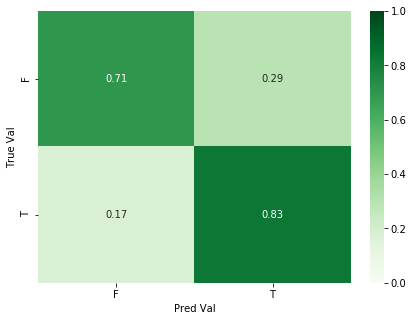

In [15]:
confusion_reporting(y_test, predictions_xgb_bin)

In [16]:
ROC = roc_auc_score(y_test, predictions_xgb)
print("ROC_Test: %.2f%%" % (ROC * 100.0))

ROC_Test: 84.54%


### Define cols to use in model

#### A full list of features that could be used in model

In [17]:
dep_col = 'cast_code'

senator_info = ['nominate_dim1', 'nominate_dim2', 'percent_campaign_vote', 'election_year', 'tenure', 
                'age', 'is_sponsor', 'sponsor_is_same_party', 'party_D', 'party_R', 'cosponsor_my_party', 
                'cosponsor_my_party^2']

bill_info = ['sponsor_party_is_lead', 'cosponsor_party_D_%', 'cosponsor_party_R_%', 
             'percent_cosponsors_lead_party', 'lead_party_D', 'sponsor_party_D', 'sponsor_party_R',
             'cosponsors', 'cosponsors_D', 'cosponsors_R', 'cosponsors_ID',
             'cosponsors^2', 'cosponsors_D^2', 'cosponsors_R^2', 'cosponsors_ID^2']

text_cols = ['summary']

indep_cols = senator_info + bill_info + text_cols

#### Features used in logit model plus text features

In [97]:
dep_col = 'cast_code'

logit_features = list(pd.read_pickle('final_features.pkl')['feature'].values)

text_cols = ['summary']

indep_cols = logit_features + text_cols

#### Random Sampling of all bills

In [98]:
scalar = StandardScaler()

y = main_df[dep_col]
X = main_df[indep_cols]

non_text_cols = [x for x in indep_cols if x not in text_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_sc = scalar.fit_transform(X_train[non_text_cols])
X_test_sc = scalar.transform(X_test[non_text_cols])

X_train_df = pd.DataFrame(X_train_sc, index=y_train.index, columns=X[non_text_cols].columns).join(X_train[text_cols])
X_test_df = pd.DataFrame(X_test_sc, index=y_test.index, columns=X[non_text_cols].columns).join(X_test[text_cols])

#### Whole bills set aside for test - randomly

In [99]:
main_df['bill_slug'] = main_df['bill_number'] + '-' + main_df['congress'].apply(lambda x: str(x))

In [100]:
unique_bills = list(main_df['bill_slug'].unique())
percent_to_subset = .3
num_to_subset = round(len(unique_bills) * percent_to_subset)
subset_bills = random.sample(unique_bills, num_to_subset)

In [101]:
scalar = StandardScaler()

train_df = main_df[~main_df['bill_slug'].isin(subset_bills)]
test_df = main_df[main_df['bill_slug'].isin(subset_bills)]

non_text_cols = [x for x in indep_cols if x not in text_cols]

y_train = train_df[dep_col]
X_train = train_df[indep_cols]

y_test = test_df[dep_col]
X_test = test_df[indep_cols]

X_train_sc = scalar.fit_transform(X_train[non_text_cols])
X_test_sc = scalar.transform(X_test[non_text_cols])

X_train_df = pd.DataFrame(X_train_sc, index=y_train.index, columns=X_train[non_text_cols].columns).join(X_train[text_cols])
X_test_df = pd.DataFrame(X_test_sc, index=y_test.index, columns=X_train[non_text_cols].columns).join(X_test[text_cols])

#### Continue with data manipulation for training and testing

In [102]:
unique_sum_train_df = pd.Series(X_train_df['summary'].unique())
unique_sum_test_df = pd.Series(X_test_df['summary'].unique())

In [103]:
X_train_df.head()

,sponsor_is_same_party,nominate_dim1,cosponsor_my_party,age,tenure,nominate_dim2,cosponsor_my_party^2,percent_campaign_vote,cosponsors^2,cosponsors,cosponsors_R^2,cosponsors_R,percent_cosponsors_lead_party,cosponsor_party_R_%,cosponsor_party_D_%,cosponsors_D,cosponsors_D^2,party_R,summary
0,-0.989290,0.485162,-0.388501,1.300247,2.720862,0.401673,-0.214879,0.410551,-0.270116,-0.509064,-0.272093,-0.449741,0.12422,0.151806,0.583149,-0.330237,-0.180991,1.017354,(This measure has not been amended since it wa...
1,1.010826,-0.655578,-0.388501,0.911253,2.720862,0.279304,-0.214879,1.756585,-0.270116,-0.509064,-0.272093,-0.449741,0.12422,0.151806,0.583149,-0.330237,-0.180991,-0.982942,(This measure has not been amended since it wa...
2,-0.989290,0.620039,-0.388501,1.689240,2.498908,-0.015820,-0.214879,0.751749,-0.270116,-0.509064,-0.272093,-0.449741,0.12422,0.151806,0.583149,-0.330237,-0.180991,1.017354,(This measure has not been amended since it wa...
3,1.010826,-0.973339,-0.388501,1.105750,2.054999,-1.746975,-0.214879,0.553596,-0.270116,-0.509064,-0.272093,-0.449741,0.12422,0.151806,0.583149,-0.330237,-0.180991,-0.982942,(This measure has not been amended since it wa...
4,1.010826,-0.996199,-0.388501,1.008501,2.498908,-0.246161,-0.214879,0.749404,-0.270116,-0.509064,-0.272093,-0.449741,0.12422,0.151806,0.583149,-0.330237,-0.180991,-0.982942,(This measure has not been amended since it wa...


### Text Vectorization

In [104]:
# Load cached model
module_path = 'universal-sentence-encoder_4'
embed = hub.load(module_path)

In [105]:
# Create embeddings 
X_train_embeddings = embed(unique_sum_train_df.values)
X_test_embeddings = embed(unique_sum_test_df.values)

In [106]:
X_train_embeddings

<tf.Tensor: shape=(170, 512), dtype=float32, numpy=
array([[-0.05092445, -0.05869472, -0.05279853, ..., -0.05145787,
        -0.05134518,  0.05795385],
       [ 0.04587507, -0.05776393, -0.05548954, ...,  0.00549307,
        -0.02611162,  0.05205261],
       [ 0.04710024, -0.04940543,  0.04922357, ..., -0.046798  ,
        -0.03070747,  0.04938825],
       ...,
       [ 0.04579428, -0.05241514,  0.03154188, ...,  0.04326781,
        -0.02163268,  0.04367857],
       [-0.01197146, -0.07224006,  0.05763955, ...,  0.05031721,
         0.03344291,  0.00411961],
       [-0.04627267, -0.04863995,  0.02554848, ...,  0.04235268,
        -0.0486377 ,  0.0479296 ]], dtype=float32)>

In [107]:
#turn the embeddings into dataframes to rejoin with the unique summaries
sum_cols = ['sum_'+str(i) for i in range(np.shape(X_train_embeddings)[1])]

vec_sum_train_df = unique_sum_train_df.to_frame(name='summary').join(pd.DataFrame(np.asarray(X_train_embeddings), 
                                                                                  columns=sum_cols))
vec_sum_test_df = unique_sum_test_df.to_frame(name='summary').join(pd.DataFrame(np.asarray(X_test_embeddings), 
                                                                                columns=sum_cols))

In [108]:
#merge the vectorized train and test dfs back onto the main train/test dfs, keeping original indexs
X_train_df['copy_index'] = X_train_df.index
X_test_df['copy_index'] = X_test_df.index

X_train_vec = X_train_df.merge(vec_sum_train_df, on='summary', how='left').set_index('copy_index')
X_test_vec = X_test_df.merge(vec_sum_test_df, on='summary', how='left').set_index('copy_index')

In [109]:
#Oversample training data
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over_vec, y_over = oversample.fit_resample(X_train_vec, y_train)

In [110]:
X_over_vec

,sponsor_is_same_party,nominate_dim1,cosponsor_my_party,age,tenure,nominate_dim2,cosponsor_my_party^2,percent_campaign_vote,cosponsors^2,cosponsors,...,sum_502,sum_503,sum_504,sum_505,sum_506,sum_507,sum_508,sum_509,sum_510,sum_511
0,-0.989290,0.485162,-0.388501,1.300247,2.720862,0.401673,-0.214879,0.410551,-0.270116,-0.509064,...,-0.017427,-0.059715,0.059354,0.038517,-0.052733,-0.055467,-0.003952,-0.051458,-0.051345,0.057954
1,1.010826,-0.655578,-0.388501,0.911253,2.720862,0.279304,-0.214879,1.756585,-0.270116,-0.509064,...,-0.017427,-0.059715,0.059354,0.038517,-0.052733,-0.055467,-0.003952,-0.051458,-0.051345,0.057954
2,-0.989290,0.620039,-0.388501,1.689240,2.498908,-0.015820,-0.214879,0.751749,-0.270116,-0.509064,...,-0.017427,-0.059715,0.059354,0.038517,-0.052733,-0.055467,-0.003952,-0.051458,-0.051345,0.057954
3,1.010826,-0.973339,-0.388501,1.105750,2.054999,-1.746975,-0.214879,0.553596,-0.270116,-0.509064,...,-0.017427,-0.059715,0.059354,0.038517,-0.052733,-0.055467,-0.003952,-0.051458,-0.051345,0.057954
4,1.010826,-0.996199,-0.388501,1.008501,2.498908,-0.246161,-0.214879,0.749404,-0.270116,-0.509064,...,-0.017427,-0.059715,0.059354,0.038517,-0.052733,-0.055467,-0.003952,-0.051458,-0.051345,0.057954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22807,1.010826,1.072677,-0.422455,0.814004,0.945228,0.909142,-0.215089,1.533809,-0.270515,-0.552920,...,-0.045145,-0.045145,0.018476,0.044881,-0.045145,-0.044891,0.045020,0.045105,-0.045145,0.045143
22808,-0.989290,-1.183656,-0.422455,-0.158480,-0.164543,-2.434398,-0.215089,-0.258949,-0.245012,-0.202073,...,0.020199,-0.083227,0.056820,0.039363,-0.068696,-0.034298,0.001313,-0.018090,0.057918,0.049895
22809,1.010826,0.821211,-0.388501,-0.644722,-0.941382,0.473654,-0.214879,-1.069149,-0.269618,-0.487136,...,-0.047265,-0.048595,0.045421,0.047974,-0.048595,0.048582,0.048578,-0.039331,-0.048551,-0.021048
22810,1.010826,0.821211,-0.422455,-0.644722,-0.941382,0.473654,-0.215089,-1.069149,-0.270515,-0.552920,...,-0.048623,-0.048623,-0.025388,0.021537,-0.048623,-0.047213,0.030427,0.044840,-0.048344,0.048607


In [111]:
print(sum(y_over == 1))
print(sum(y_over == 0))

11406
11406


### Run Model

In [112]:
# Define pipeline
clf_xgb = xgb.sklearn.XGBClassifier(nthread=-1, seed=1234, 
                                    learning_rate =0.01,
                                    n_estimators=1000,
                                    max_depth=5,
                                    min_child_weight=1,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    objective= 'binary:logistic',
                                    scale_pos_weight=1)

In [113]:
#define cols for training
model_cols = non_text_cols + sum_cols

In [114]:
# Fit model
clf_xgb.fit(X_over_vec[model_cols], y_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=1234, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1234, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [115]:
# Test accuracy on test data
predictions_xgb = clf_xgb.predict_proba(X_test_vec[model_cols])
predictions_xgb = [item[1] for item in predictions_xgb]
predictions_xgb_bin = [round(item) for item in predictions_xgb]

[[1365  678]
 [ 562 4461]]
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      2043
           1       0.87      0.89      0.88      5023

    accuracy                           0.82      7066
   macro avg       0.79      0.78      0.78      7066
weighted avg       0.82      0.82      0.82      7066

Accuracy score: 0.8245
F1 score: 0.878


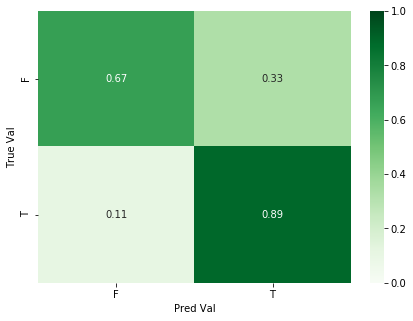

In [116]:
confusion_reporting(y_test, predictions_xgb_bin)

In [117]:
ROC = roc_auc_score(y_test, predictions_xgb)
print("ROC_Test: %.2f%%" % (ROC * 100.0))

ROC_Test: 85.59%


In [124]:
features = indep_cols
features_fn = 'final_xgb_features.sav'
joblib.dump(features, features_fn)

['final_xgb_features.sav']

In [123]:
scaler = scalar
scaler_fn = 'final_xgb_scaler.sav'
joblib.dump(scaler, scaler_fn)

['final_xgb_scaler.sav']

In [118]:
model = clf_xgb
model_fn = 'final_xgb_model.sav'
joblib.dump(model, model_fn)

['final_xgb_model.sav']

# Working Zone

In [114]:
for i in range(1, len(non_text_cols)+1):
    model_cols = sum_cols + non_text_cols[:i]
    clf_xgb.fit(X_over_vec[model_cols], y_over)
    
    predictions_xgb = clf_xgb.predict_proba(X_test_vec[model_cols])
    predictions_xgb = [item[1] for item in predictions_xgb]
    
    ROC = roc_auc_score(y_test, predictions_xgb)
    print('Num cols beyond summary: ', i, 
          '\nLatest feature add: ', non_text_cols[i-1],
          "\nROC_Test: %.2f%%" % (ROC * 100.0), '\n')

Num cols beyond summary:  1 
Latest feature add:  nominate_dim1 
ROC_Test: 95.86% 

Num cols beyond summary:  2 
Latest feature add:  nominate_dim2 
ROC_Test: 95.88% 

Num cols beyond summary:  3 
Latest feature add:  percent_campaign_vote 
ROC_Test: 95.94% 

Num cols beyond summary:  4 
Latest feature add:  election_year 
ROC_Test: 95.81% 

Num cols beyond summary:  5 
Latest feature add:  tenure 
ROC_Test: 95.82% 

Num cols beyond summary:  6 
Latest feature add:  age 
ROC_Test: 95.97% 

Num cols beyond summary:  7 
Latest feature add:  is_sponsor 
ROC_Test: 95.78% 

Num cols beyond summary:  8 
Latest feature add:  sponsor_is_same_party 
ROC_Test: 96.84% 

Num cols beyond summary:  9 
Latest feature add:  party_D 
ROC_Test: 96.81% 

Num cols beyond summary:  10 
Latest feature add:  party_R 
ROC_Test: 96.81% 

Num cols beyond summary:  11 
Latest feature add:  cosponsor_my_party 
ROC_Test: 96.98% 

Num cols beyond summary:  12 
Latest feature add:  cosponsor_my_party^2 
ROC_Test: 96

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields summary

In [138]:
main_df[['summary', 'party_D']]

,summary,party_D
0,(This measure has not been amended since it wa...,0
1,(This measure has not been amended since it wa...,1
2,(This measure has not been amended since it wa...,0
3,(This measure has not been amended since it wa...,1
4,(This measure has not been amended since it wa...,1
...,...,...
23221,"Coronavirus Aid, Relief, and Economic Securit...",1
23222,"Coronavirus Aid, Relief, and Economic Securit...",1
23223,"Coronavirus Aid, Relief, and Economic Securit...",0
23224,"Coronavirus Aid, Relief, and Economic Securit...",0


In [139]:
main_df[['summary']]

,summary
0,(This measure has not been amended since it wa...
1,(This measure has not been amended since it wa...
2,(This measure has not been amended since it wa...
3,(This measure has not been amended since it wa...
4,(This measure has not been amended since it wa...
...,...
23221,"Coronavirus Aid, Relief, and Economic Securit..."
23222,"Coronavirus Aid, Relief, and Economic Securit..."
23223,"Coronavirus Aid, Relief, and Economic Securit..."
23224,"Coronavirus Aid, Relief, and Economic Securit..."
